## Vehicle Insurance Claim Fraud Detection

This project aims to detect fraudulent insurance claims in vehicle data using a complete machine learning workflow. The dataset consists of various features about claims, vehicles, and policyholders. The final goal is to build a reliable and accurate model to flag suspicious claims, using EDA, preprocessing, class balancing, feature engineering, model training, and evaluation.

In this notebook we will be loading the data, analysing feature correlation and importance, handling missing values, feature selection and encoding and finally spliting the dataset into train and test

In [278]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score

from sklearn.model_selection import KFold

In [279]:
data = pd.read_csv('../data/fraud_oracle.csv')

## 1. EDA and preprocessing

## 1.1 Data Visualisation and feature selection

Lets visualise the data

In [280]:
pd.set_option('display.max_columns', None)
data.head(5)

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


We are going to remove PolicyNumber as a feature because its a type of ID and will have no service in training the models

In [281]:
data = data.drop('PolicyNumber',axis=1)

Based on common knowledge we are going to drop the columns that give redundant information or no information at all that will help the models learn

In [282]:
columns = ['Year','WeekOfMonth','DayOfWeek','DayOfWeekClaimed','MonthClaimed','WeekOfMonthClaimed']
for col in columns:
    data = data.drop(col,axis=1)

First we will do a statistical analysis on the features and their distribution depending on the target class.

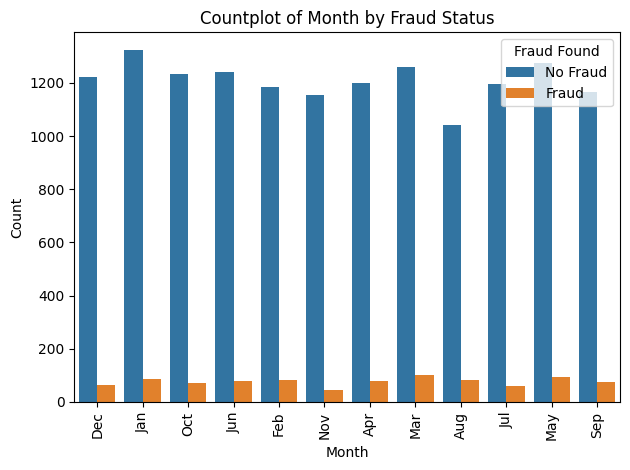

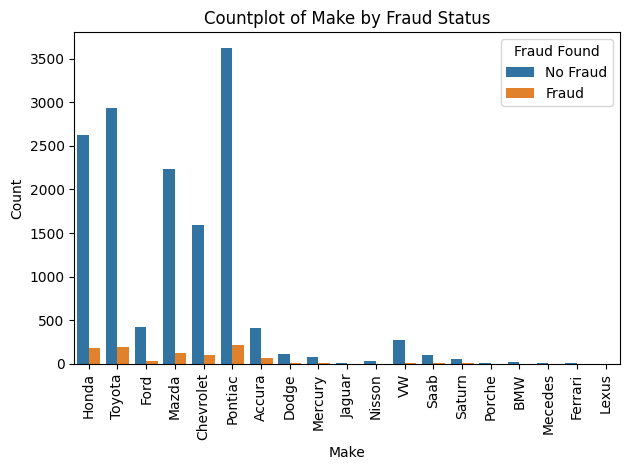

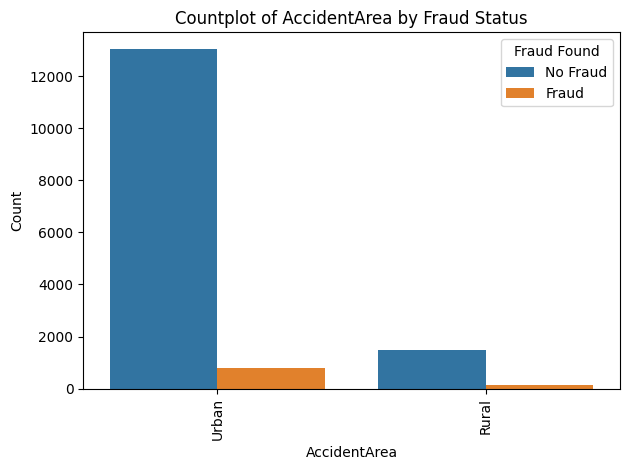

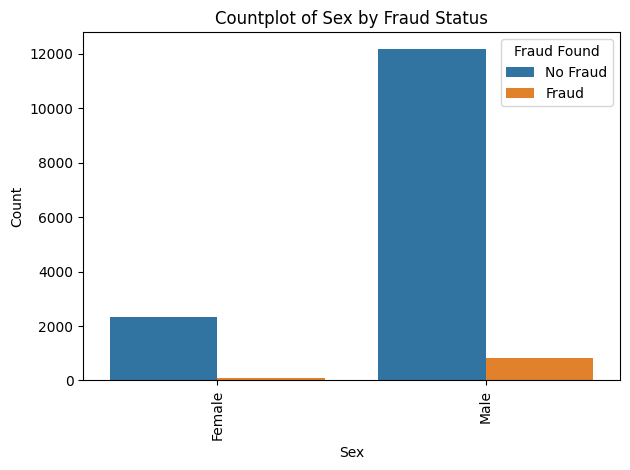

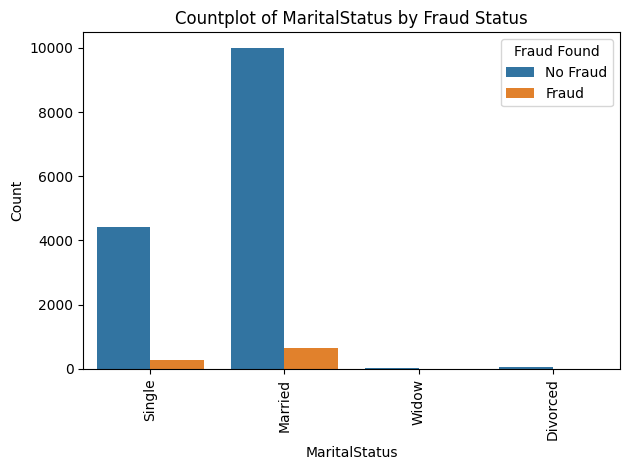

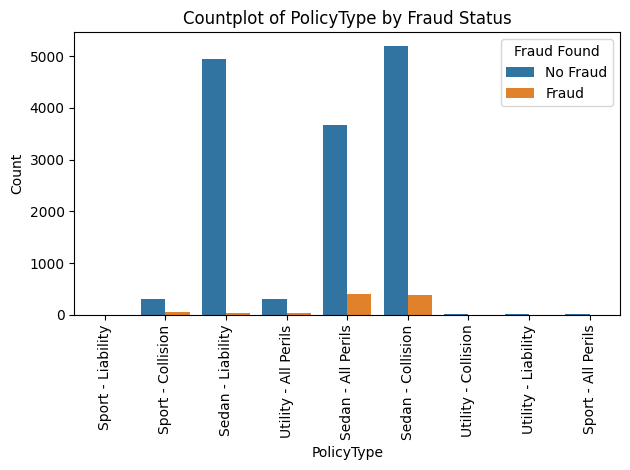

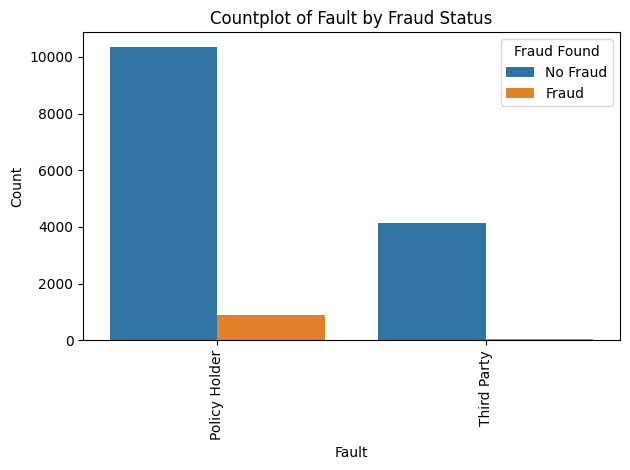

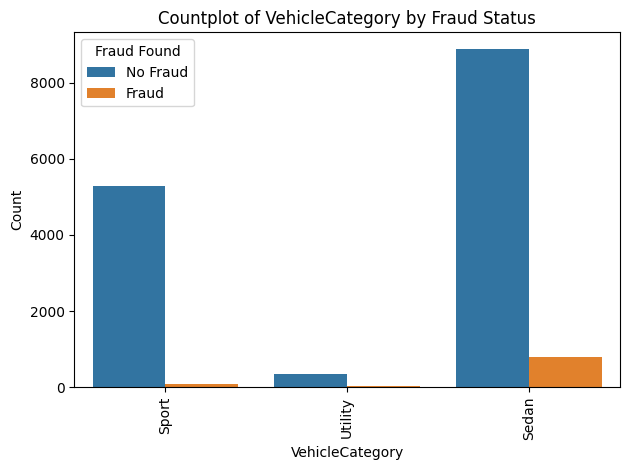

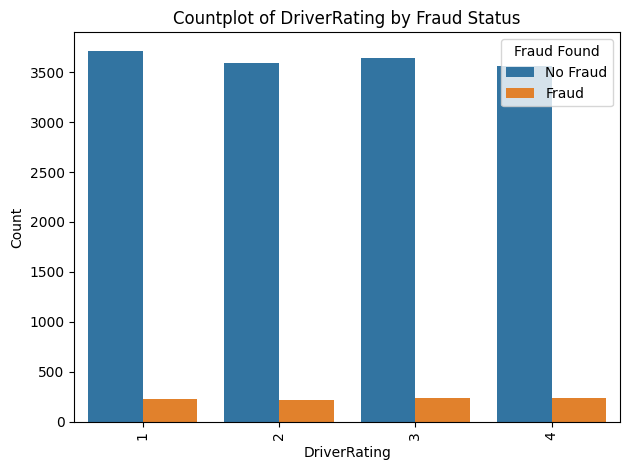

In [283]:
columns=['Month','Make','AccidentArea','Sex','MaritalStatus','PolicyType','Fault','VehicleCategory','DriverRating']
for col in columns:
    sns.countplot(data=data, x=col, hue="FraudFound_P")
    plt.xticks(rotation='vertical')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f'Countplot of {col} by Fraud Status')
    plt.legend(title="Fraud Found", labels=["No Fraud", "Fraud"])
    plt.tight_layout()
    plt.show()

Based on what we see on the histograms, we decided to drop DriverRating, Month because of the pretty uniform distribution of the target class, the models would have very little to learn from and we will drop make because it adds bias

In [284]:
data = data.drop('DriverRating',axis=1)
data = data.drop('Month',axis=1)
data = data.drop('Make',axis=1)

In [285]:
data.head()

,AccidentArea,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,RepNumber,Deductible,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,BasePolicy
0,Urban,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,12,300,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,Liability
1,Urban,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,15,400,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,Collision
2,Urban,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,7,400,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,Collision
3,Rural,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,400,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,Liability
4,Urban,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,3,400,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,Collision


Lets create some pie charts for further visualisation

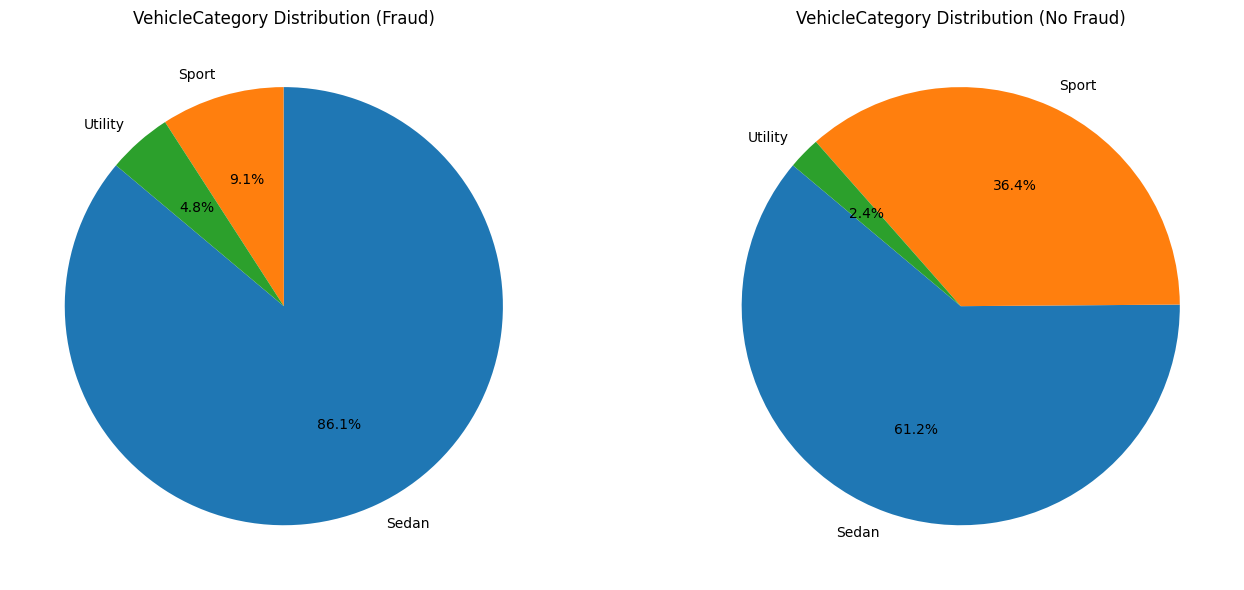

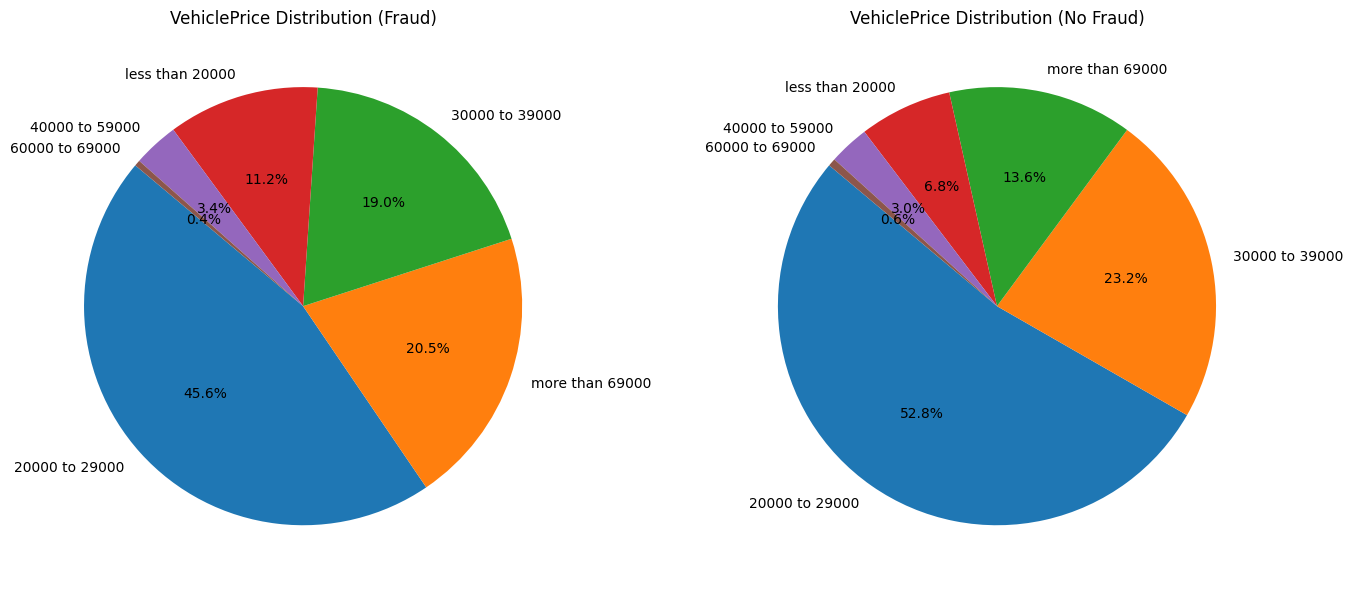

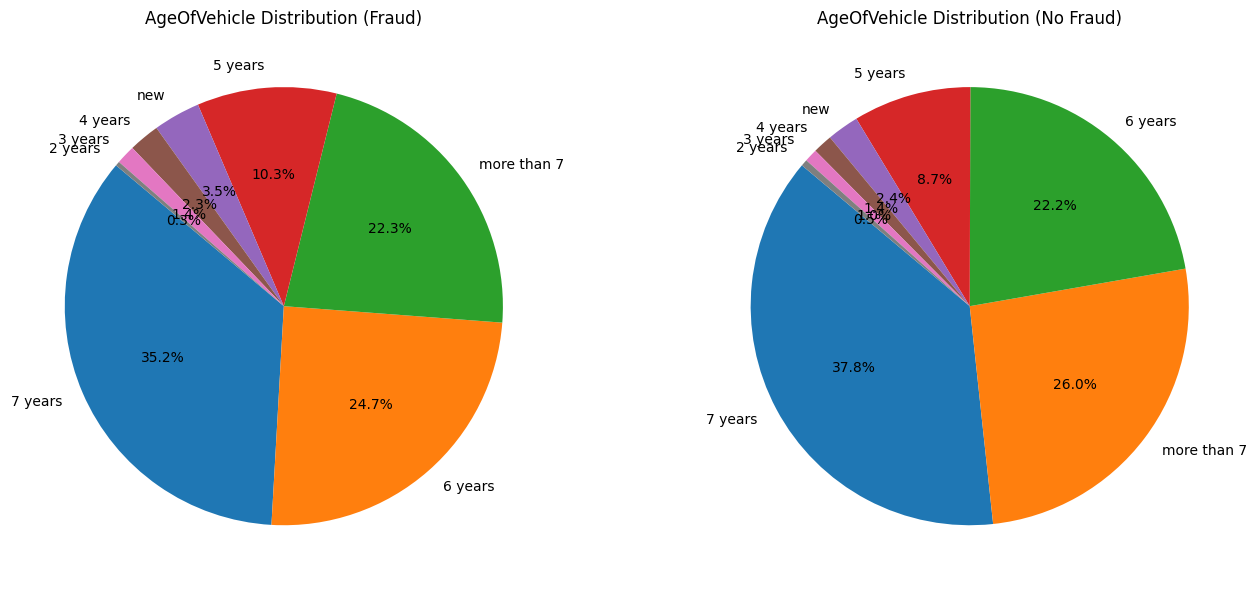

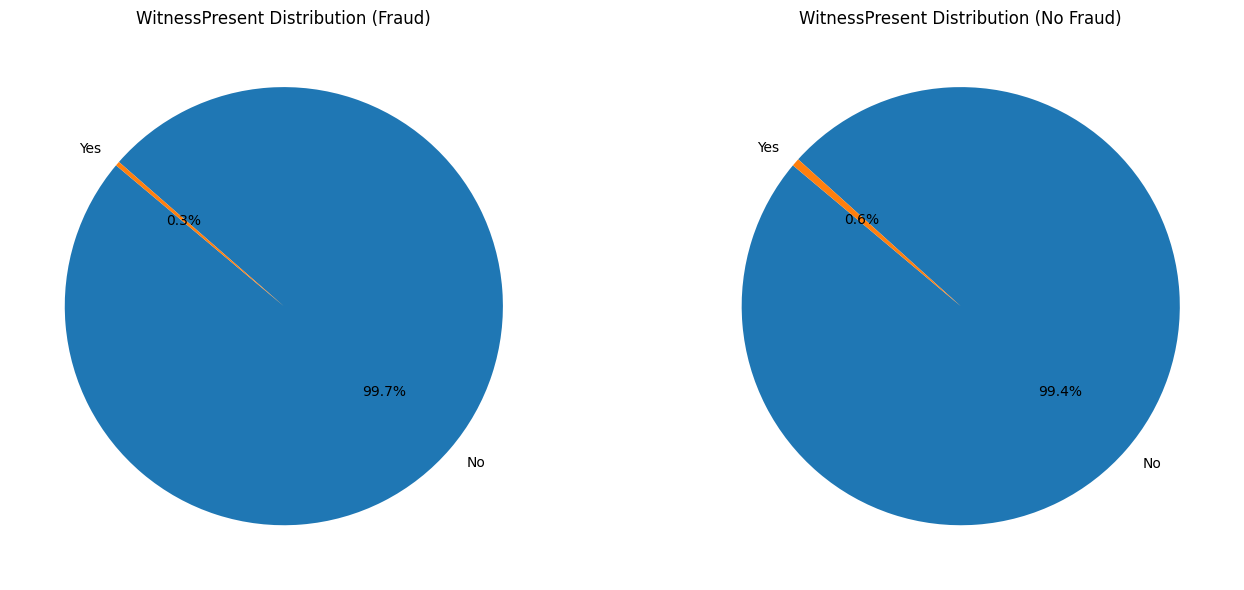

In [286]:
columns = ['VehicleCategory','VehiclePrice','AgeOfVehicle','WitnessPresent']
for col in columns:
    fraud_data = data[data["FraudFound_P"] == 1][col].value_counts()
    no_fraud_data = data[data["FraudFound_P"] == 0][col].value_counts()
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].pie(fraud_data, labels=fraud_data.index, autopct='%1.1f%%', startangle=140)
    axes[0].set_title(f'{col} Distribution (Fraud)')

    axes[1].pie(no_fraud_data, labels=no_fraud_data.index, autopct='%1.1f%%', startangle=140)
    axes[1].set_title(f'{col} Distribution (No Fraud)')

    plt.tight_layout()
    plt.show()

In this section, the dataset was thoroughly explored to understand the distribution and relationships of key features with respect to the target variable, FraudFound_P. Visualizations such as count plots and histograms were used to identify patterns and potential predictors of fraud. Based on domain knowledge and the observed distributions, several columns were removed, including PolicyNumber (an identifier), Month, Make, and DriverRating, as they were either redundant, non-informative, or potentially introduced bias. This careful feature selection laid the groundwork for more effective preprocessing and modeling in subsequent steps.


## 1.2 Handling Missing Values

Now we will analyse and handle null values if there are any

In [287]:
data.isna().sum()

AccidentArea            0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
RepNumber               0
Deductible              0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
BasePolicy              0
dtype: int64

Amazing, there are no null values in our dataset, so we can continue to do encoding on the features that are cathegorical, lets visualise the data again

In [288]:
data.head()

,AccidentArea,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,RepNumber,Deductible,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,BasePolicy
0,Urban,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,12,300,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,Liability
1,Urban,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,15,400,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,Collision
2,Urban,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,7,400,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,Collision
3,Rural,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,400,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,Liability
4,Urban,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,3,400,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,Collision


A comprehensive check for missing values was conducted across all features in the dataset. The analysis confirmed that there were no null or missing entries, allowing the workflow to proceed directly to encoding without the need for imputation or additional data cleaning. This ensured that the dataset was complete and ready for further transformation.


## 1.3 Feature Encoding

In [289]:
for col in data.columns:
    unique_count = data[col].nunique()
    print(f"{col}: {unique_count} unique values")

AccidentArea: 2 unique values
Sex: 2 unique values
MaritalStatus: 4 unique values
Age: 66 unique values
Fault: 2 unique values
PolicyType: 9 unique values
VehicleCategory: 3 unique values
VehiclePrice: 6 unique values
FraudFound_P: 2 unique values
RepNumber: 16 unique values
Deductible: 4 unique values
Days_Policy_Accident: 5 unique values
Days_Policy_Claim: 4 unique values
PastNumberOfClaims: 4 unique values
AgeOfVehicle: 8 unique values
AgeOfPolicyHolder: 9 unique values
PoliceReportFiled: 2 unique values
WitnessPresent: 2 unique values
AgentType: 2 unique values
NumberOfSuppliments: 4 unique values
AddressChange_Claim: 5 unique values
NumberOfCars: 5 unique values
BasePolicy: 3 unique values


Lets select the features that we are going to label encode, these are features with binary values, ex: yes or no...

In [290]:
le = LabelEncoder()
columns=['AccidentArea','Sex','Fault','PoliceReportFiled','WitnessPresent','AgentType']	
for col in columns:
    data[col]=le.fit_transform(data[col])
data.head()  

,AccidentArea,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,RepNumber,Deductible,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,BasePolicy
0,1,0,Single,21,0,Sport - Liability,Sport,more than 69000,0,12,300,more than 30,more than 30,none,3 years,26 to 30,0,0,0,none,1 year,3 to 4,Liability
1,1,1,Single,34,0,Sport - Collision,Sport,more than 69000,0,15,400,more than 30,more than 30,none,6 years,31 to 35,1,0,0,none,no change,1 vehicle,Collision
2,1,1,Married,47,0,Sport - Collision,Sport,more than 69000,0,7,400,more than 30,more than 30,1,7 years,41 to 50,0,0,0,none,no change,1 vehicle,Collision
3,0,1,Married,65,1,Sedan - Liability,Sport,20000 to 29000,0,4,400,more than 30,more than 30,1,more than 7,51 to 65,1,0,0,more than 5,no change,1 vehicle,Liability
4,1,0,Single,27,1,Sport - Collision,Sport,more than 69000,0,3,400,more than 30,more than 30,none,5 years,31 to 35,0,0,0,none,no change,1 vehicle,Collision


We are going to do ordinal encoding on features that have values that can be organised ordinally

In [291]:

pd.set_option('display.max_columns', None)
for col in ['VehiclePrice','AgeOfVehicle','AgeOfPolicyHolder','Days_Policy_Accident','Days_Policy_Claim','NumberOfCars','NumberOfSuppliments','PastNumberOfClaims',  'AddressChange_Claim']:
    print(data[col].unique())
    print('\n')

['more than 69000' '20000 to 29000' '30000 to 39000' 'less than 20000'
 '40000 to 59000' '60000 to 69000']


['3 years' '6 years' '7 years' 'more than 7' '5 years' 'new' '4 years'
 '2 years']


['26 to 30' '31 to 35' '41 to 50' '51 to 65' '21 to 25' '36 to 40'
 '16 to 17' 'over 65' '18 to 20']


['more than 30' '15 to 30' 'none' '1 to 7' '8 to 15']


['more than 30' '15 to 30' '8 to 15' 'none']


['3 to 4' '1 vehicle' '2 vehicles' '5 to 8' 'more than 8']


['none' 'more than 5' '3 to 5' '1 to 2']


['none' '1' '2 to 4' 'more than 4']


['1 year' 'no change' '4 to 8 years' '2 to 3 years' 'under 6 months']




In [292]:
mappings = {
    'VehiclePrice': {'less than 20000':0,'20000 to 29000':1,'30000 to 39000':2,'40000 to 59000':3,'60000 to 69000':4,'more than 69000':5},  
    'AgeOfVehicle': {'more than 7':0,'7 years':1,'6 years':2,'5 years':3,'4 years':4,'3 years':5,'2 years':6,'new':7},
    'AgeOfPolicyHolder': {'16 to 17':0,'18 to 20':1,'21 to 25':2,'26 to 30':3,'31 to 35':4,'36 to 40':5,'41 to 50':6,'51 to 65':7,'over 65':8},
    'Days_Policy_Accident': {'none':0, '1 to 7':1 ,  '8 to 15':2,'15 to 30':3, 'more than 30':4},
    'Days_Policy_Claim': {'none':0,'8 to 15':1,'15 to 30':2,'more than 30':3},
    'NumberOfCars': {'more than 8':0,'5 to 8':1,'3 to 4':2,'2 vehicles':3,'1 vehicle':4},
    'NumberOfSuppliments': {'none':0,'1 to 2':1,'3 to 5':2,'more than 5':3},
    'PastNumberOfClaims': {'none':0, '1':1 ,'2 to 4':2, 'more than 4':3},
    'AddressChange_Claim': {'1 year':2, 'no change':0, '4 to 8 years':4 ,'2 to 3 years':3, 'under 6 months':1}
}
for col,mapping in mappings.items():
    data[col] = data[col].map(mapping)

In [293]:
data.head()

,AccidentArea,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,RepNumber,Deductible,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,BasePolicy
0,1,0,Single,21,0,Sport - Liability,Sport,5,0,12,300,4,3,0,5,3,0,0,0,0,2,2,Liability
1,1,1,Single,34,0,Sport - Collision,Sport,5,0,15,400,4,3,0,2,4,1,0,0,0,0,4,Collision
2,1,1,Married,47,0,Sport - Collision,Sport,5,0,7,400,4,3,1,1,6,0,0,0,0,0,4,Collision
3,0,1,Married,65,1,Sedan - Liability,Sport,1,0,4,400,4,3,1,0,7,1,0,0,3,0,4,Liability
4,1,0,Single,27,1,Sport - Collision,Sport,5,0,3,400,4,3,0,3,4,0,0,0,0,0,4,Collision


Now we will proceed with the columns that need one hot encoding

In [294]:
columns=['MaritalStatus','PolicyType','VehicleCategory','BasePolicy']
encoder = OneHotEncoder(sparse_output=False)
for col in columns:
    encoded_data = encoder.fit_transform(data[[col]])
    column_names = encoder.get_feature_names_out([col])
    encoded_df = pd.DataFrame(encoded_data, columns=column_names)
    data = data.drop(col,axis=1)
    data = pd.concat([data, encoded_df], axis=1)
data.head()

,AccidentArea,Sex,Age,Fault,VehiclePrice,FraudFound_P,RepNumber,Deductible,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,PolicyType_Sedan - All Perils,PolicyType_Sedan - Collision,PolicyType_Sedan - Liability,PolicyType_Sport - All Perils,PolicyType_Sport - Collision,PolicyType_Sport - Liability,PolicyType_Utility - All Perils,PolicyType_Utility - Collision,PolicyType_Utility - Liability,VehicleCategory_Sedan,VehicleCategory_Sport,VehicleCategory_Utility,BasePolicy_All Perils,BasePolicy_Collision,BasePolicy_Liability
0,1,0,21,0,5,0,12,300,4,3,0,5,3,0,0,0,0,2,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1,1,34,0,5,0,15,400,4,3,0,2,4,1,0,0,0,0,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1,1,47,0,5,0,7,400,4,3,1,1,6,0,0,0,0,0,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0,1,65,1,1,0,4,400,4,3,1,0,7,1,0,0,3,0,4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1,0,27,1,5,0,3,400,4,3,0,3,4,0,0,0,0,0,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [295]:
data.shape

(15420, 38)

Categorical features were encoded to prepare the data for machine learning algorithms. Binary categorical variables were transformed using label encoding, while ordinal features with a logical order were mapped to numerical values. Multi-class categorical features were converted using one-hot encoding, resulting in a fully numerical dataset. This encoding process was essential for ensuring compatibility with a wide range of machine learning models and for preserving the information contained in categorical variables.


## 1.4 Data Scaling

Now that we have encoded our features, lets standardise and normalise the appropriate ones

In [296]:
ss = StandardScaler()
ns = MinMaxScaler()

columns = ['RepNumber','Age','VehiclePrice','AgeOfVehicle','AgeOfPolicyHolder','Days_Policy_Accident','Days_Policy_Claim','NumberOfCars','NumberOfSuppliments']

for col in columns:
    data[[col]] = ns.fit_transform(data[[col]])

data[['Deductible']] = ss.fit_transform(data[['Deductible']])



In [297]:
data.head()

,AccidentArea,Sex,Age,Fault,VehiclePrice,FraudFound_P,RepNumber,Deductible,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,PolicyType_Sedan - All Perils,PolicyType_Sedan - Collision,PolicyType_Sedan - Liability,PolicyType_Sport - All Perils,PolicyType_Sport - Collision,PolicyType_Sport - Liability,PolicyType_Utility - All Perils,PolicyType_Utility - Collision,PolicyType_Utility - Liability,VehicleCategory_Sedan,VehicleCategory_Sport,VehicleCategory_Utility,BasePolicy_All Perils,BasePolicy_Collision,BasePolicy_Liability
0,1,0,0.2625,0,1.0,0,0.733333,-2.450633,1.0,1.0,0,0.714286,0.375,0,0,0,0.0,2,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1,1,0.4250,0,1.0,0,0.933333,-0.175298,1.0,1.0,0,0.285714,0.500,1,0,0,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1,1,0.5875,0,1.0,0,0.400000,-0.175298,1.0,1.0,1,0.142857,0.750,0,0,0,0.0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0,1,0.8125,1,0.2,0,0.200000,-0.175298,1.0,1.0,1,0.000000,0.875,1,0,0,1.0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1,0,0.3375,1,1.0,0,0.133333,-0.175298,1.0,1.0,0,0.428571,0.500,0,0,0,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [298]:
data.describe()

,AccidentArea,Sex,Age,Fault,VehiclePrice,FraudFound_P,RepNumber,Deductible,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,PolicyType_Sedan - All Perils,PolicyType_Sedan - Collision,PolicyType_Sedan - Liability,PolicyType_Sport - All Perils,PolicyType_Sport - Collision,PolicyType_Sport - Liability,PolicyType_Utility - All Perils,PolicyType_Utility - Collision,PolicyType_Utility - Liability,VehicleCategory_Sedan,VehicleCategory_Sport,VehicleCategory_Utility,BasePolicy_All Perils,BasePolicy_Collision,BasePolicy_Liability
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,1.542000e+04,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.00000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,0.896368,0.843061,0.498196,0.271725,0.359222,0.059857,0.498885,-3.919044e-16,0.993174,0.997817,1.334176,0.199175,0.611487,0.027756,0.005642,0.015629,0.391786,0.242607,0.975292,0.004929,0.689040,0.303761,0.00227,0.265045,0.362127,0.323411,0.001427,0.022568,0.000065,0.022049,0.001946,0.001362,0.627173,0.347471,0.025357,0.288521,0.386641,0.324838
std,0.304792,0.363755,0.168655,0.444863,0.288603,0.237230,0.306663,1.000032e+00,0.071565,0.032695,1.023588,0.199951,0.174488,0.164279,0.074904,0.124039,0.416370,0.900073,0.095868,0.070033,0.462901,0.459896,0.04759,0.441372,0.480631,0.467793,0.037746,0.148527,0.008053,0.146849,0.044067,0.036880,0.483572,0.476182,0.157211,0.453090,0.486996,0.468329
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.450633e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.387500,0.000000,0.200000,0.000000,0.266667,-1.752982e-01,1.000000,1.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.475000,0.000000,0.200000,0.000000,0.466667,-1.752982e-01,1.000000,1.000000,1.000000,0.142857,0.625000,0.000000,0.000000,0.000000,0.333333,0.000000,1.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.600000,1.000000,0.400000,0.000000,0.733333,-1.752982e-01,1.000000,1.000000,2.000000,0.285714,0.750000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.650707e+00,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


To ensure that all numerical features contributed equally to model training, standardization and normalization techniques were applied. Features with varying scales were transformed using StandardScaler and MinMaxScaler, bringing them to a common scale. This step improved the stability and convergence of machine learning algorithms, particularly those sensitive to feature magnitude.


## 1.5 Correlation Matrix and feature analysis

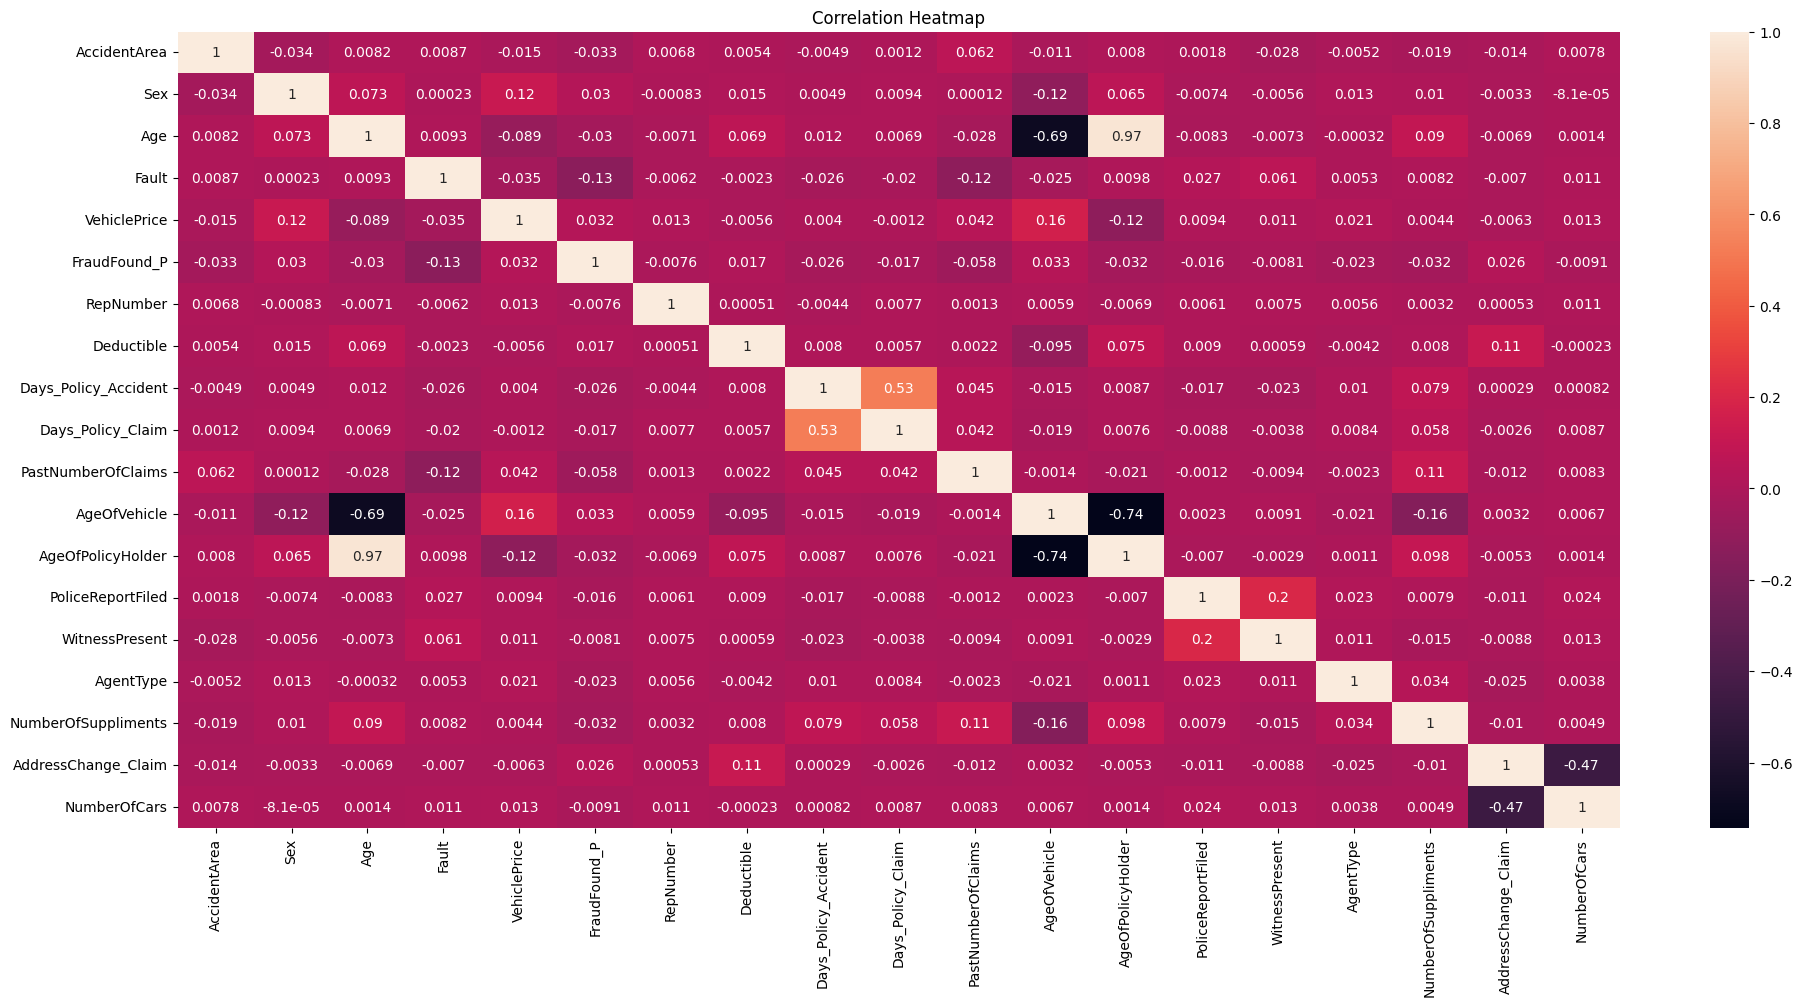

In [299]:
original_categorical_cols = [
    'MaritalStatus', 'PolicyType', 'VehicleCategory','BasePolicy'
]

one_hot_columns = [col for col in data.columns if any(col.startswith(base) for base in original_categorical_cols)]

dat_cor = data.drop(one_hot_columns,axis=1)

fig = plt.figure(figsize=(20, 10))
correlation_data = dat_cor
dataplot = sns.heatmap(correlation_data.corr(), annot=True)
plt.tight_layout()
plt.title("Correlation Heatmap")
plt.show()

In [300]:
data = data.drop('AgeOfPolicyHolder',axis=1)

A correlation matrix was generated and visualized to assess the relationships between features and to detect potential multicollinearity. This analysis helped identify redundant or highly correlated variables, guiding further feature selection. By focusing on the most relevant predictors, the risk of overfitting was reduced and model interpretability was enhanced.


## 1.6 Data Split

In [301]:
X = data.drop('FraudFound_P',axis=1)
y = data[['FraudFound_P']]

In [302]:
X.head()

,AccidentArea,Sex,Age,Fault,VehiclePrice,RepNumber,Deductible,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,PolicyType_Sedan - All Perils,PolicyType_Sedan - Collision,PolicyType_Sedan - Liability,PolicyType_Sport - All Perils,PolicyType_Sport - Collision,PolicyType_Sport - Liability,PolicyType_Utility - All Perils,PolicyType_Utility - Collision,PolicyType_Utility - Liability,VehicleCategory_Sedan,VehicleCategory_Sport,VehicleCategory_Utility,BasePolicy_All Perils,BasePolicy_Collision,BasePolicy_Liability
0,1,0,0.2625,0,1.0,0.733333,-2.450633,1.0,1.0,0,0.714286,0,0,0,0.0,2,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1,1,0.4250,0,1.0,0.933333,-0.175298,1.0,1.0,0,0.285714,1,0,0,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1,1,0.5875,0,1.0,0.400000,-0.175298,1.0,1.0,1,0.142857,0,0,0,0.0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0,1,0.8125,1,0.2,0.200000,-0.175298,1.0,1.0,1,0.000000,1,0,0,1.0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1,0,0.3375,1,1.0,0.133333,-0.175298,1.0,1.0,0,0.428571,0,0,0,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [303]:
y.head()

,FraudFound_P
0,0
1,0
2,0
3,0
4,0


In [304]:
X_work, X_test, y_work, y_test = train_test_split(X,y,test_size=0.2, stratify=y, shuffle=True, random_state=38)

In [305]:
X_train, X_val, y_train, y_val = train_test_split(X_work,y_work,test_size=0.3, stratify=y_work, shuffle=True, random_state=38)

The dataset was split into training, validation, and test sets using stratified sampling to maintain the original class distribution. This approach ensured that each subset was representative of the overall data, which is particularly important for imbalanced classification problems. The resulting splits provided a solid foundation for fair model evaluation and comparison.


## 1.7 Feature Selection and Importance

In [306]:

original_categorical_cols = [
    'MaritalStatus', 'PolicyType', 'VehicleCategory','BasePolicy'
]


one_hot_columns = [col for col in X.columns if any(col.startswith(base) for base in original_categorical_cols)]

print("One-hot encoded columns:")
print(one_hot_columns)
print()

One-hot encoded columns:
['MaritalStatus_Divorced', 'MaritalStatus_Married', 'MaritalStatus_Single', 'MaritalStatus_Widow', 'PolicyType_Sedan - All Perils', 'PolicyType_Sedan - Collision', 'PolicyType_Sedan - Liability', 'PolicyType_Sport - All Perils', 'PolicyType_Sport - Collision', 'PolicyType_Sport - Liability', 'PolicyType_Utility - All Perils', 'PolicyType_Utility - Collision', 'PolicyType_Utility - Liability', 'VehicleCategory_Sedan', 'VehicleCategory_Sport', 'VehicleCategory_Utility', 'BasePolicy_All Perils', 'BasePolicy_Collision', 'BasePolicy_Liability']



In [307]:
model = RandomForestClassifier(random_state=38)

excluded = one_hot_columns
X_filtered = X_train.drop(columns=excluded,axis=1)
feature_names = X_filtered.columns

model.fit(X_filtered, y_train)
importances = model.feature_importances_


feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(10))  

C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


                Feature  Importance
2                   Age    0.316833
5             RepNumber    0.225627
10         AgeOfVehicle    0.090744
4          VehiclePrice    0.073414
14  NumberOfSuppliments    0.073279
9    PastNumberOfClaims    0.069784
3                 Fault    0.026466
15  AddressChange_Claim    0.025188
6            Deductible    0.019470
0          AccidentArea    0.019270


In [308]:
br = 0
column_names = []
for col in feature_importance_df['Feature']:
    column_names.append(col)
    br += 1
    if br == 10:
        break

print(column_names)

column_names = column_names + one_hot_columns

print(column_names)

['Age', 'RepNumber', 'AgeOfVehicle', 'VehiclePrice', 'NumberOfSuppliments', 'PastNumberOfClaims', 'Fault', 'AddressChange_Claim', 'Deductible', 'AccidentArea']
['Age', 'RepNumber', 'AgeOfVehicle', 'VehiclePrice', 'NumberOfSuppliments', 'PastNumberOfClaims', 'Fault', 'AddressChange_Claim', 'Deductible', 'AccidentArea', 'MaritalStatus_Divorced', 'MaritalStatus_Married', 'MaritalStatus_Single', 'MaritalStatus_Widow', 'PolicyType_Sedan - All Perils', 'PolicyType_Sedan - Collision', 'PolicyType_Sedan - Liability', 'PolicyType_Sport - All Perils', 'PolicyType_Sport - Collision', 'PolicyType_Sport - Liability', 'PolicyType_Utility - All Perils', 'PolicyType_Utility - Collision', 'PolicyType_Utility - Liability', 'VehicleCategory_Sedan', 'VehicleCategory_Sport', 'VehicleCategory_Utility', 'BasePolicy_All Perils', 'BasePolicy_Collision', 'BasePolicy_Liability']


In [309]:
for col in data.columns:
    if col not in column_names and col != 'FraudFound_P':
        X_val = X_val.drop(col,axis=1)
        X_test = X_test.drop(col,axis=1)
        X_train = X_train.drop(col,axis=1)
        X_work = X_work.drop(col,axis=1)

In [310]:
X_train.shape

(8635, 29)

Feature importance was assessed using a Random Forest classifier, which ranked predictors based on their contribution to the model’s performance. The top features were selected for inclusion in the final dataset, while less informative variables were removed. This targeted selection process improved model efficiency and focused learning on the most impactful attributes.

## 1.8 Class Balancing and pre-train analysis

Now lets check the balance of the target variable and if need be do some sampling

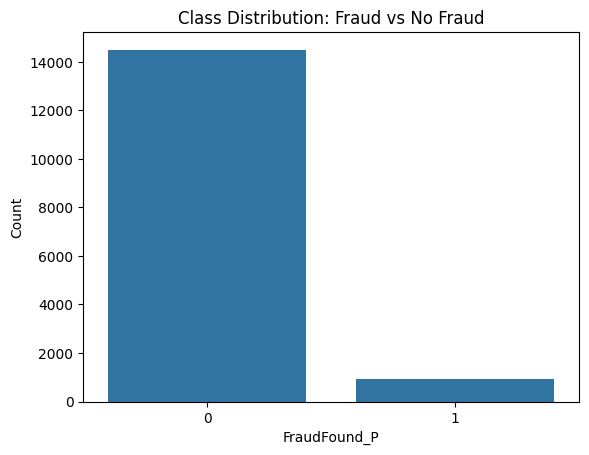

FraudFound_P
0    94.014267
1     5.985733
Name: proportion, dtype: float64


In [311]:

sns.countplot(x='FraudFound_P', data=data)
plt.title('Class Distribution: Fraud vs No Fraud')
plt.xlabel('FraudFound_P')
plt.ylabel('Count')
plt.show()


print(data['FraudFound_P'].value_counts(normalize=True) * 100)

C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy Score: 0.9376

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      3480
           1       0.35      0.05      0.09       221

    accuracy                           0.94      3701
   macro avg       0.65      0.52      0.53      3701
weighted avg       0.91      0.94      0.92      3701



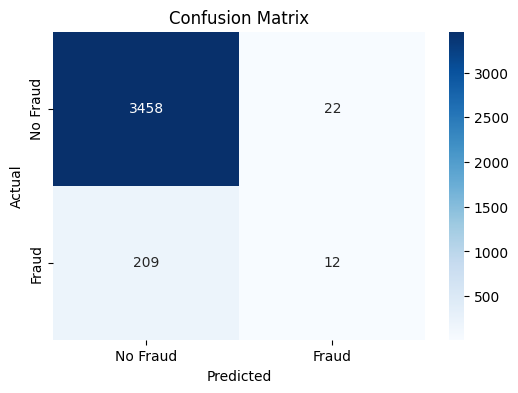

In [312]:
rf = RandomForestClassifier(random_state=38)
rf.fit(X_train, y_train)


y_pred = rf.predict(X_val)


acc = accuracy_score(y_val, y_pred)
print(f"Accuracy Score: {acc:.4f}")


print("\nClassification Report:")
print(classification_report(y_val, y_pred))


cm = confusion_matrix(y_val, y_pred)


plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

As we can see the class is not at all evenly distributed, so we are going to use a combination of undersampling and oversampling

In [313]:
rus = RandomUnderSampler(random_state=38)
X_res, y_res = rus.fit_resample(X_train, y_train)
X_work_res, y_work_res = rus.fit_resample(X_work,y_work)


C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_featu

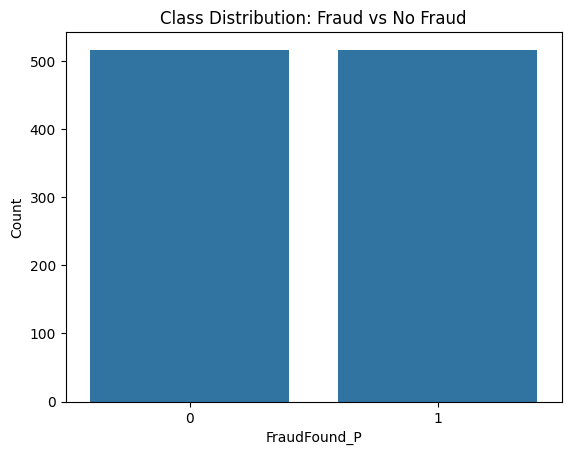

FraudFound_P
0    50.0
1    50.0
Name: proportion, dtype: float64


In [314]:
data_res = pd.concat([X_res, y_res], axis=1)


sns.countplot(x='FraudFound_P', data=data_res)
plt.title('Class Distribution: Fraud vs No Fraud')
plt.xlabel('FraudFound_P')
plt.ylabel('Count')
plt.show()


print(data_res['FraudFound_P'].value_counts(normalize=True) * 100)

In [315]:
data_res.shape

(1034, 30)

C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy Score: 0.6406

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.63      0.77      3480
           1       0.12      0.80      0.21       221

    accuracy                           0.64      3701
   macro avg       0.55      0.72      0.49      3701
weighted avg       0.93      0.64      0.73      3701



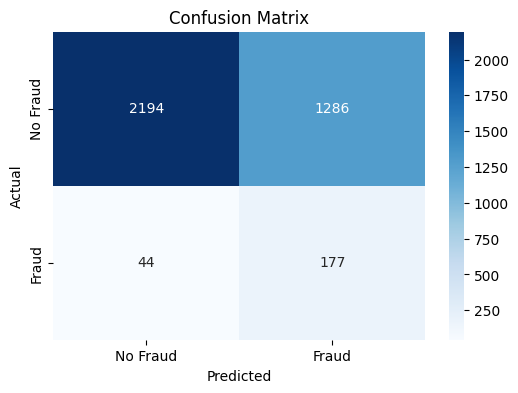

In [316]:

rf = RandomForestClassifier(random_state=38)
rf.fit(X_res, y_res)


y_pred = rf.predict(X_val)


acc = accuracy_score(y_val, y_pred)
print(f"Accuracy Score: {acc:.4f}")


print("\nClassification Report:")
print(classification_report(y_val, y_pred))


cm = confusion_matrix(y_val, y_pred)


plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In this segment, the class distribution of the target variable was examined, revealing a significant imbalance between fraudulent and non-fraudulent claims. To address this, random undersampling was applied to the training data, ensuring that both classes were equally represented and thus reducing the risk of model bias toward the majority class. The effectiveness of this balancing was visualized using count plots before and after resampling. Following this, a Random Forest classifier was trained on the balanced dataset and evaluated on the validation set. Performance metrics, including accuracy, precision, recall, and a confusion matrix, were reported to establish a baseline for subsequent model development. This step was crucial to ensure that future models would be trained on data that fairly represents both classes, improving their ability to detect fraudulent claims.


## 2. Model Training

## 2.1 Round 1

In [317]:
def compare_models(models: dict, X_test, y_test):
    """
    Compare multiple classification models.
    
    Args:
        models (dict): A dictionary with model names as keys and trained model objects as values.
        X_test: Test feature set.
        y_test: True test labels.
    """
    accuracies = {}
    recalls = {}

    for name, model in models.items():
        print(f"\n===== {name} =====")
        y_pred = model.predict(X_test)

       
        acc = accuracy_score(y_test, y_pred)
        accuracies[name] = acc
        print(f"Accuracy: {acc:.4f}")

        recall = recall_score(y_test, y_pred)
        recalls[name] = recall
        print(f"Recall: {recall:.4f}")
       
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

    
    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(recalls.keys()), y=list(recalls.values()))
    plt.title('Model Recall Comparison')
    plt.ylabel('Recall')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

In [318]:
dt = DecisionTreeClassifier(random_state=38)
knn = KNeighborsClassifier()
svm = SVC(random_state=38)
rf = RandomForestClassifier(random_state=38)
xgb = XGBClassifier()

In [319]:
dt.fit(X_res,y_res)
knn.fit(X_res,y_res)
svm.fit(X_res,y_res)
rf.fit(X_res,y_res)
xgb.fit(X_res,y_res)

C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)


===== DecisionTree =====
Accuracy: 0.6647
Recall: 0.7014

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.66      0.79      3480
           1       0.12      0.70      0.20       221

    accuracy                           0.66      3701
   macro avg       0.54      0.68      0.49      3701
weighted avg       0.92      0.66      0.75      3701



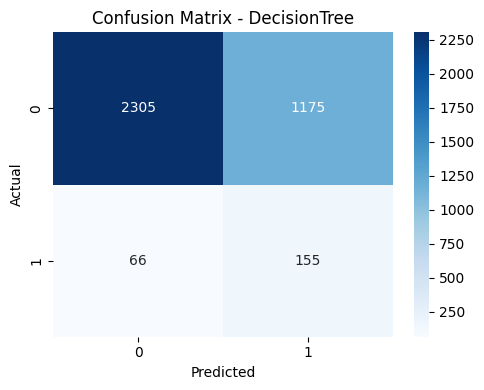


===== KNN =====
Accuracy: 0.6344
Recall: 0.8009

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.62      0.76      3480
           1       0.12      0.80      0.21       221

    accuracy                           0.63      3701
   macro avg       0.55      0.71      0.48      3701
weighted avg       0.93      0.63      0.73      3701



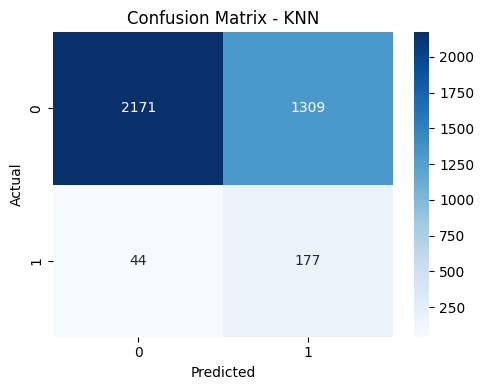


===== SVM =====
Accuracy: 0.5825
Recall: 0.9321

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.56      0.72      3480
           1       0.12      0.93      0.21       221

    accuracy                           0.58      3701
   macro avg       0.56      0.75      0.46      3701
weighted avg       0.94      0.58      0.69      3701



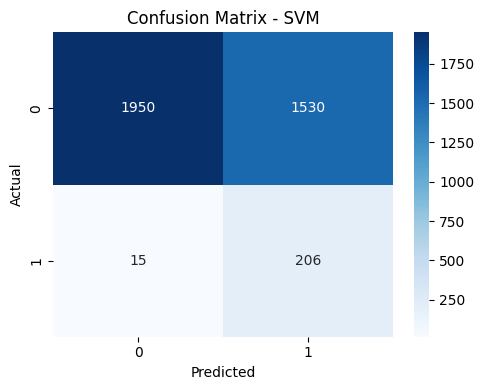


===== RandomForest =====
Accuracy: 0.6406
Recall: 0.8009

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.63      0.77      3480
           1       0.12      0.80      0.21       221

    accuracy                           0.64      3701
   macro avg       0.55      0.72      0.49      3701
weighted avg       0.93      0.64      0.73      3701



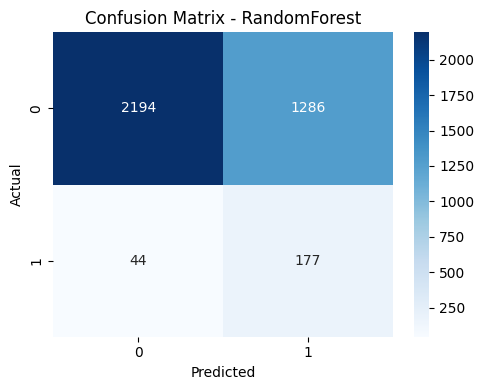


===== XGB =====
Accuracy: 0.6490
Recall: 0.7466

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.64      0.77      3480
           1       0.12      0.75      0.20       221

    accuracy                           0.65      3701
   macro avg       0.55      0.69      0.49      3701
weighted avg       0.92      0.65      0.74      3701



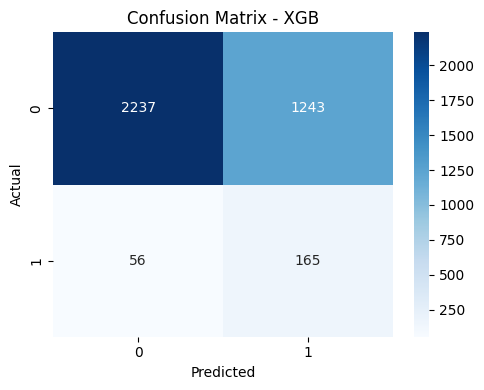

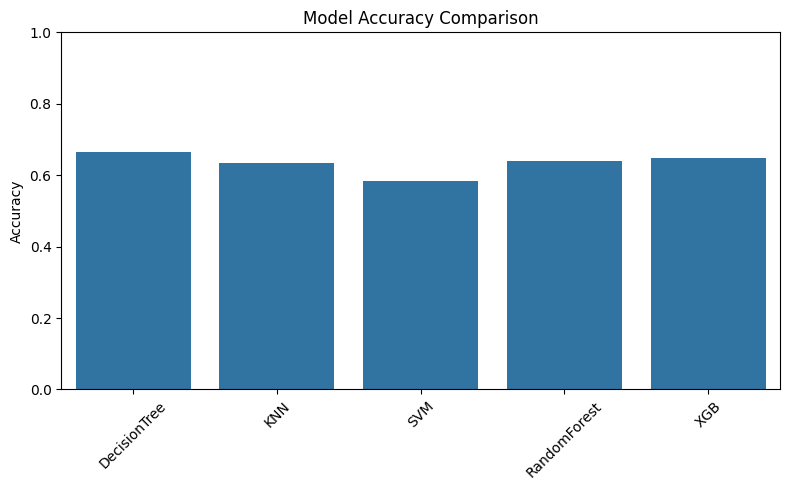

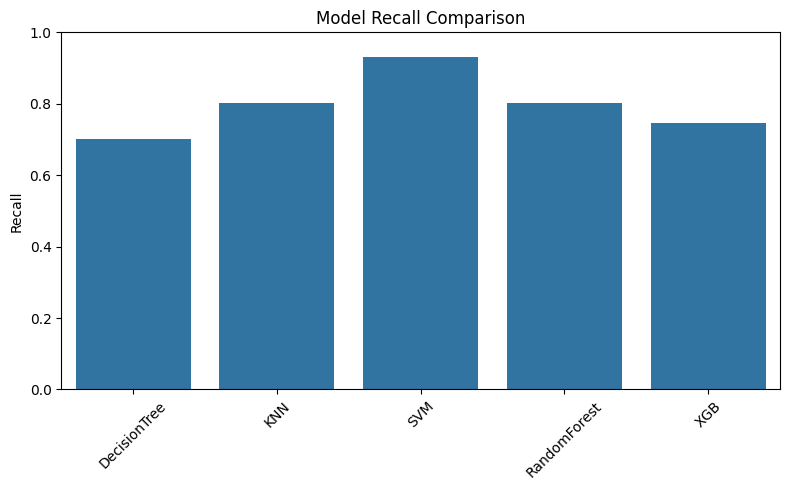

In [320]:
model_dict = {
    "DecisionTree" : dt,
    "KNN" : knn,
    "SVM" : svm,
    "RandomForest" : rf,
    "XGB" : xgb 
    }
compare_models(model_dict,X_val,y_val)

We decide to go forward with SVM, XGB and Random Forest. The thought proccess is that SVM had best recall for class 1 and the other two can learn to improve in further training

This section focused on the initial training and comparison of several classification algorithms, including Decision Tree, K-Nearest Neighbors, Support Vector Machine, Random Forest, and XGBoost. Each model was trained on the balanced training data and evaluated on the validation set. The results were analyzed using accuracy scores, detailed classification reports, and confusion matrices, providing insight into each model’s strengths and weaknesses, particularly in identifying fraudulent claims. Based on these results, SVM, Random Forest, and XGBoost were selected for further tuning, as they demonstrated the most promising recall and overall performance for the minority (fraud) class. This comparative analysis established a strong foundation for targeted hyperparameter optimization in the next phase.


## 2.2 Round 2

## 2.2.1 Hyperparamether optimisation and tuning

C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best SVM Params: {'kernel': 'rbf', 'gamma': 'scale', 'C': np.float64(0.027825594022071243)}


C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best RF Params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 20}


c:\Users\david\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:37:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB Params: {'subsample': 1.0, 'n_estimators': 10, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

===== SVM =====
Accuracy: 0.3472
Recall: 0.9548

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.31      0.47      3480
           1       0.08      0.95      0.15       221

    accuracy                           0.35      3701
   macro avg       0.54      0.63      0.31      3701
weighted avg       0.94      0.35      0.45      3701



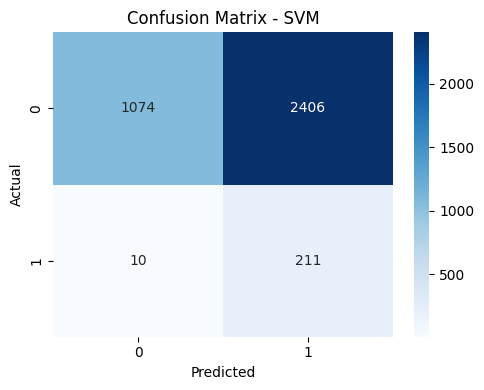


===== RandomForest =====
Accuracy: 0.5936
Recall: 0.9412

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.57      0.73      3480
           1       0.12      0.94      0.22       221

    accuracy                           0.59      3701
   macro avg       0.56      0.76      0.47      3701
weighted avg       0.94      0.59      0.70      3701



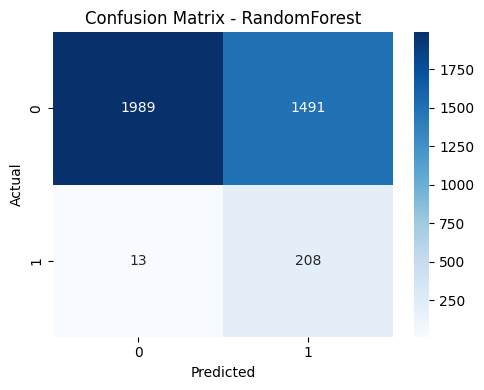


===== XGB =====
Accuracy: 0.5850
Recall: 0.9548

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.56      0.72      3480
           1       0.12      0.95      0.22       221

    accuracy                           0.58      3701
   macro avg       0.56      0.76      0.47      3701
weighted avg       0.94      0.58      0.69      3701



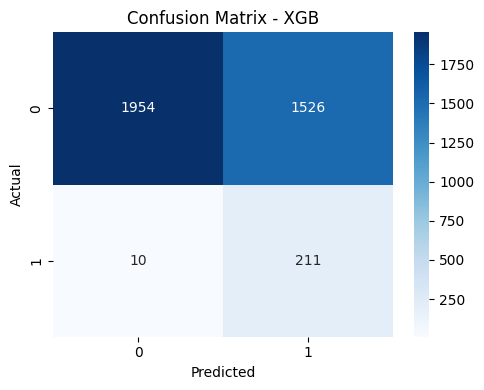

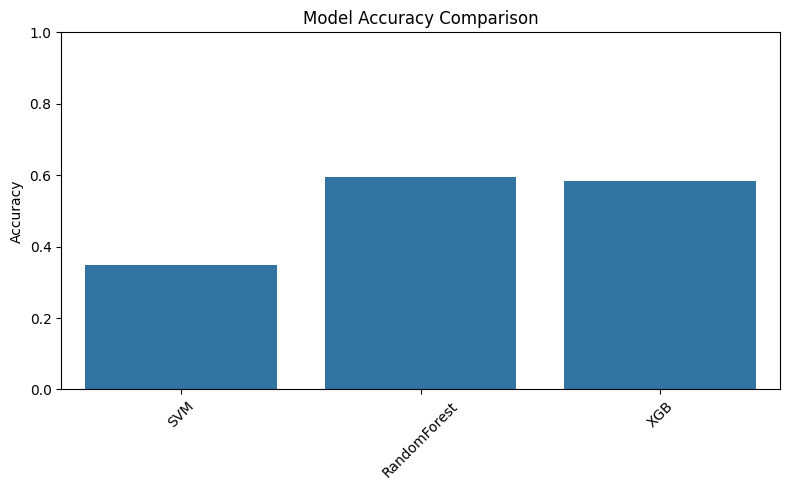

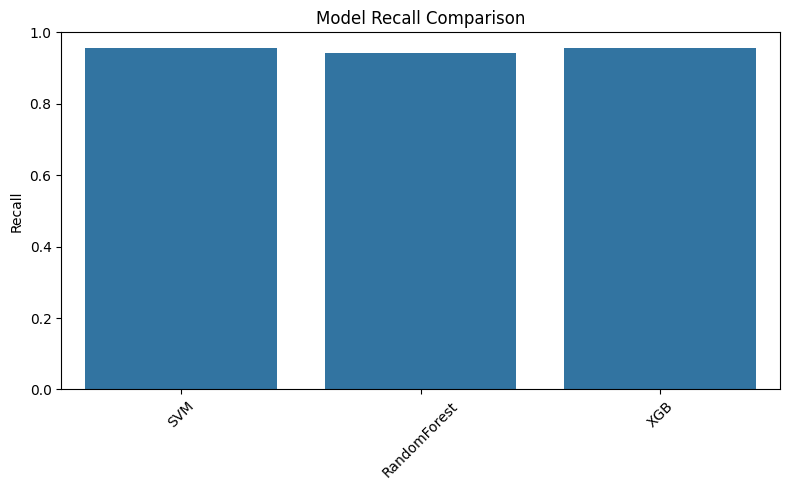

In [321]:
recall_scorer = make_scorer(recall_score, pos_label=1)
precision_scorer = make_scorer(precision_score, pos_label=1)
f1_scorer = make_scorer(f1_score, pos_label=1)

k = KFold(n_splits=10, shuffle=True, random_state=38)


svm_model = SVC(class_weight='balanced', probability=True)
svm_params = {
    'C': np.logspace(-2, 2, 10),  
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}


svm_search = RandomizedSearchCV(svm_model, svm_params, n_iter=10, cv=k, scoring={'recall': recall_scorer,'precision': precision_scorer,'f1': f1_scorer,'accuracy': 'accuracy'} ,refit='recall', random_state=38, n_jobs=-1)
svm_search.fit(X_res, y_res)
print("Best SVM Params:", svm_search.best_params_)



rf_model = RandomForestClassifier(class_weight='balanced',random_state=38)
rf_params = {
    'n_estimators': [10,25,50,100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
rf_search = RandomizedSearchCV(rf_model, rf_params, n_iter=10, cv=k, scoring={'recall': recall_scorer,'precision': precision_scorer,'f1': f1_scorer,'accuracy': 'accuracy'} ,refit='recall', random_state=38, n_jobs=-1)
rf_search.fit(X_res, y_res)
print("Best RF Params:", rf_search.best_params_)



xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=38)
xgb_params = {
    'n_estimators': [10, 25, 50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
xgb_search = RandomizedSearchCV(xgb_model, xgb_params, n_iter=10, cv=k, scoring={'recall': recall_scorer,'precision': precision_scorer,'f1': f1_scorer,'accuracy': 'accuracy'} ,refit='recall', random_state=38, n_jobs=-1)
xgb_search.fit(X_res, y_res)
print("Best XGB Params:", xgb_search.best_params_)

svm = svm_search.best_estimator_
rf = rf_search.best_estimator_
xgb = xgb_search.best_estimator_

model_dict = {
    "SVM" : svm,
    "RandomForest" : rf,
    "XGB" : xgb 
    }
compare_models(model_dict,X_val,y_val)

In this phase, the focus shifted to hyperparameter optimization for the three most promising models: SVM, Random Forest, and XGBoost. Using RandomizedSearchCV with cross-validation, each model’s parameters were systematically tuned to maximize recall, precision, F1-score, and accuracy. The best configurations for each model were identified and then evaluated on the validation set. The results were compared to determine which model and parameter set offered the best balance between detecting fraudulent claims and minimizing false positives. This rigorous tuning process ensured that the selected models were not only accurate but also robust in identifying the critical minority class.


## 2.3 Round 3

## 2.3.1 Applying stacking model

C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[[2314 1166]
 [  53  168]]
              precision    recall  f1-score   support

           0       0.98      0.66      0.79      3480
           1       0.13      0.76      0.22       221

    accuracy                           0.67      3701
   macro avg       0.55      0.71      0.50      3701
weighted avg       0.93      0.67      0.76      3701



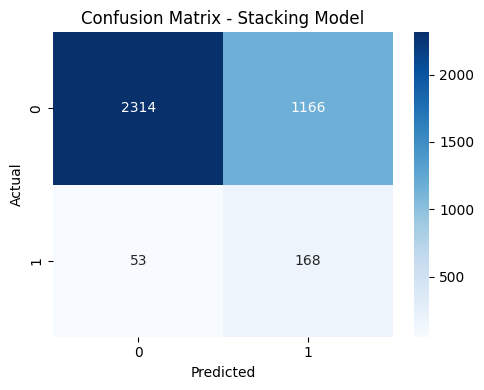

In [322]:
from sklearn.ensemble import StackingClassifier

k = KFold(n_splits=5,shuffle=True,random_state=38)

svm_stacking = SVC(probability=True, kernel='rbf',gamma='scale', C=0.027825594022071243, random_state=38)
rf_stacking = RandomForestClassifier(n_estimators=200,min_samples_split=10,min_samples_leaf=4,max_depth=20,class_weight='balanced',random_state=38)
xgb_stacking = XGBClassifier(subsample=1.0,n_estimators=10,max_depth=3,learning_rate=0.1,colsample_bytree=0.8,eval_metric='logloss',random_state=38)

meta_learner = XGBClassifier(
    eval_metric='logloss',
    random_state=38
)

base_learners = [
    ('svm', svm_stacking),
    ('rf', rf_stacking),
    ('xgb', xgb_stacking)
]


meta_learner = XGBClassifier()


stacked_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=k,
    stack_method='predict_proba',  
    n_jobs=-1,
    passthrough=False  
)


stacked_model.fit(X_res, y_res)


y_pred = stacked_model.predict(X_val)


print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))


cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - Stacking Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


Building on the optimized models from the previous round, this segment introduced a stacking ensemble approach. The best-performing SVM, Random Forest, and XGBoost models were combined as base learners, with an XGBoost classifier serving as the meta-learner. The stacking model was trained on the balanced dataset and evaluated on the validation set. The ensemble’s performance was assessed using confusion matrices and classification reports, which demonstrated improved predictive power and robustness compared to individual models. This ensemble approach leveraged the strengths of each base model, resulting in a more reliable system for detecting insurance claim fraud.


## 3. Model Testing


===== XGB =====
Accuracy: 0.6038
Recall: 0.9622

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.58      0.73      2899
           1       0.13      0.96      0.23       185

    accuracy                           0.60      3084
   macro avg       0.56      0.77      0.48      3084
weighted avg       0.94      0.60      0.70      3084



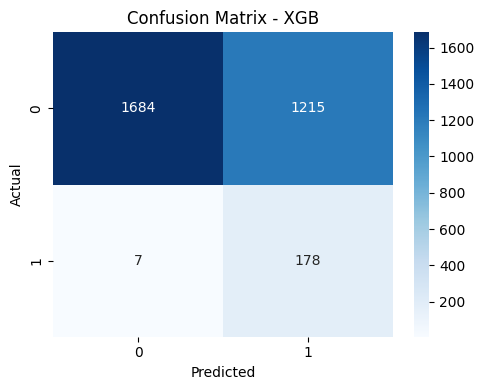


===== SVM =====
Accuracy: 0.3564
Recall: 0.9622

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.32      0.48      2899
           1       0.08      0.96      0.15       185

    accuracy                           0.36      3084
   macro avg       0.54      0.64      0.32      3084
weighted avg       0.94      0.36      0.46      3084



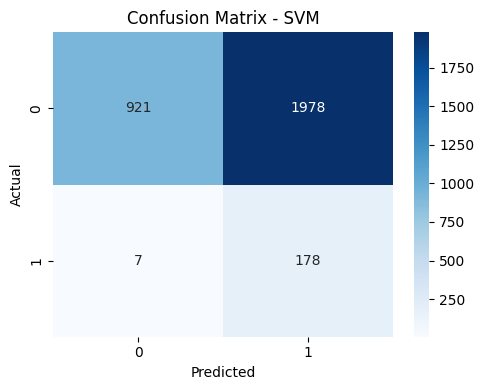


===== RF =====
Accuracy: 0.6154
Recall: 0.9568

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.59      0.74      2899
           1       0.13      0.96      0.23       185

    accuracy                           0.62      3084
   macro avg       0.56      0.78      0.49      3084
weighted avg       0.94      0.62      0.71      3084



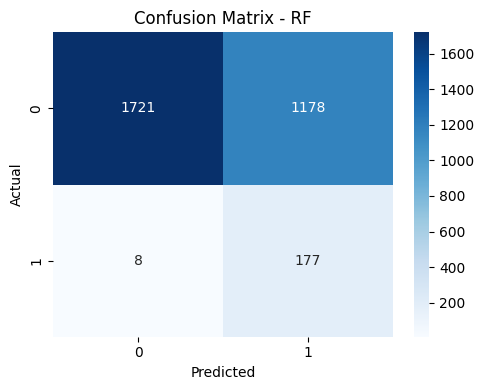


===== Stacked =====
Accuracy: 0.6793
Recall: 0.7730

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.67      0.80      2899
           1       0.13      0.77      0.22       185

    accuracy                           0.68      3084
   macro avg       0.56      0.72      0.51      3084
weighted avg       0.93      0.68      0.76      3084



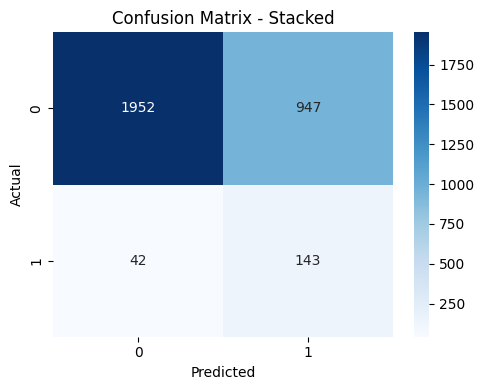

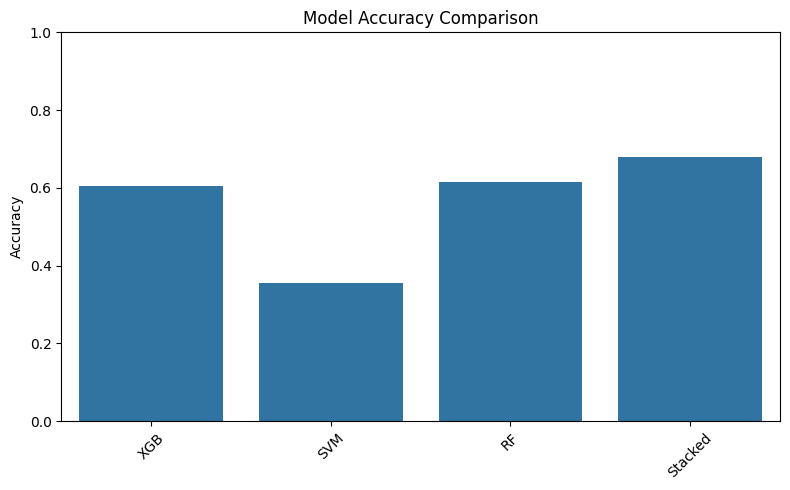

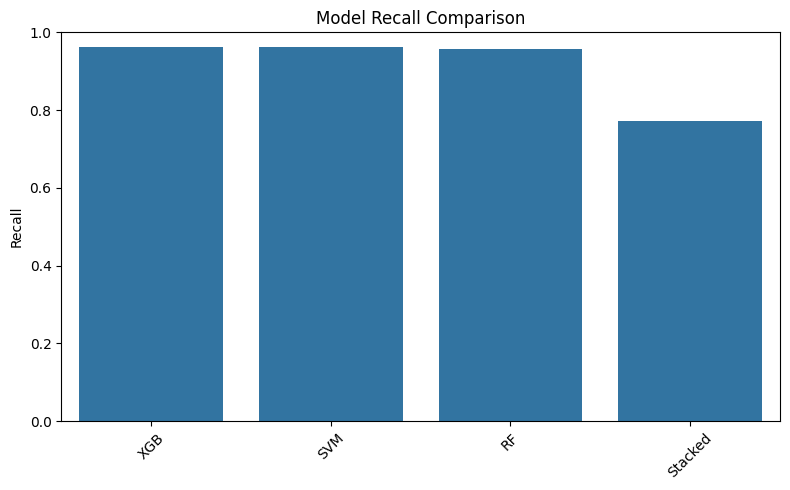

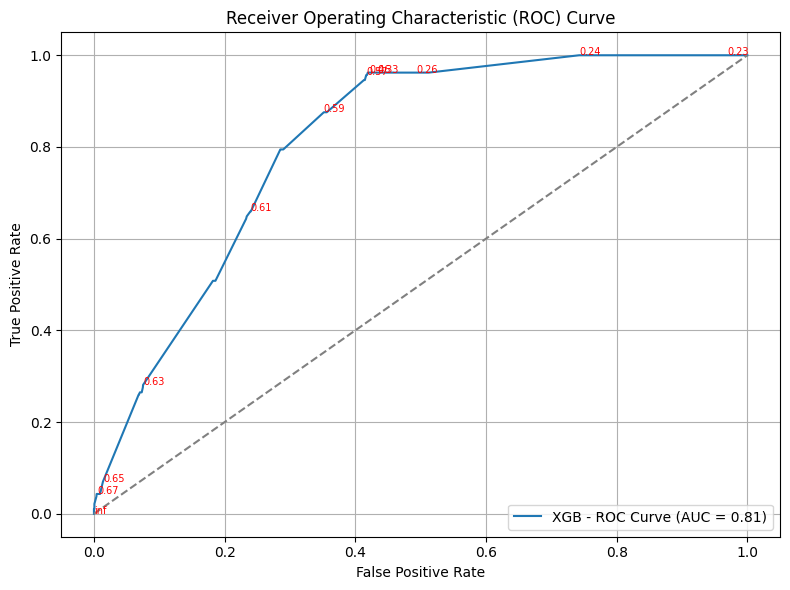

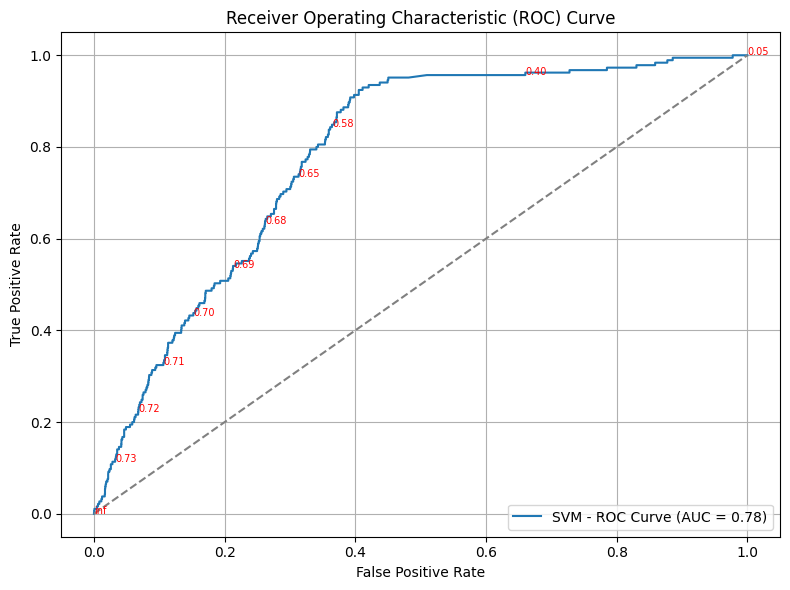

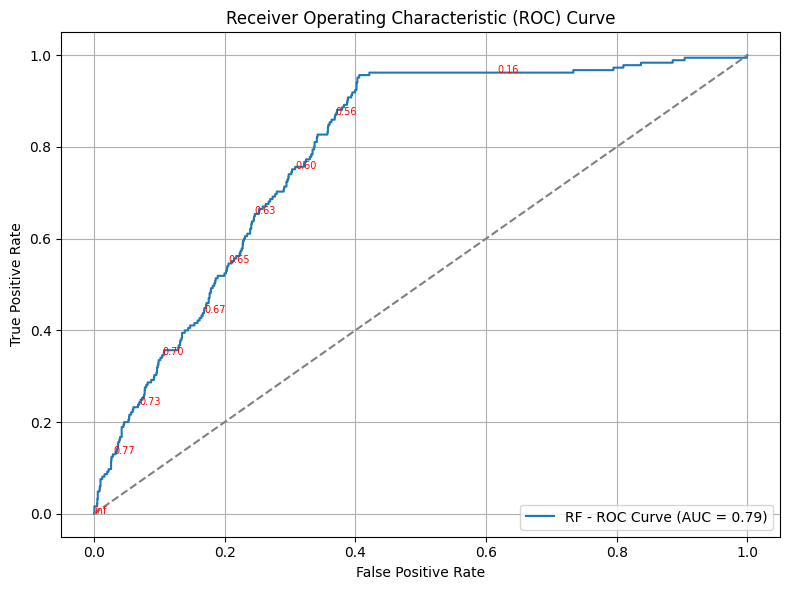

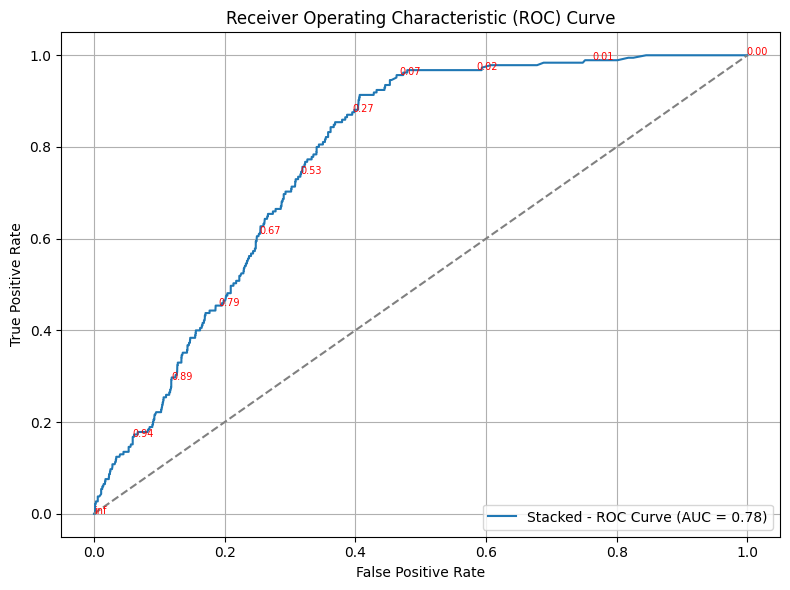

In [323]:
model_dict = {
    "XGB" : xgb,
    "SVM" : svm,
    "RF" : rf,
    "Stacked" : stacked_model
    }
compare_models(model_dict,X_test,y_test)
for name, model in model_dict.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} - ROC Curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    for i in range(0, len(thresholds), max(1, len(thresholds)//10)):
        plt.text(fpr[i], tpr[i], f"{thresholds[i]:.2f}", fontsize=7, color='red')  
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

The final segment involved a comprehensive evaluation of the tuned individual models and the stacking ensemble on the unseen test set. Each model’s performance was assessed using accuracy, precision, recall, F1-score, and confusion matrices. This comparison provided a clear understanding of how each approach generalized to new data, highlighting the strengths and limitations of both individual and ensemble methods. The results informed the selection of the most effective model for deployment, ensuring that the chosen solution offered both high accuracy and strong recall for fraudulent claims, which is essential for real-world fraud detection applications.